# Frank-Wolfe algorithm on constrained Lasso problem

Author: Alexandre Gramfort

Problem considered is:

$$
\min \|Ax-b\|^2  s.t. \|x\|_1 \leq r
$$


In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
n_samples = 30
n_features = 40
nnz = n_features // 10  # number of non-zeros in the true solution

rng = np.random.RandomState(42)
A = rng.randn(n_samples, n_features)
x_true = np.concatenate((np.ones(nnz), -np.ones(nnz), -np.zeros(n_features - 2*nnz)))

noise = 0.1 * rng.randn(n_samples)
b = A.dot(x_true) + noise

<Container object of 3 artists>

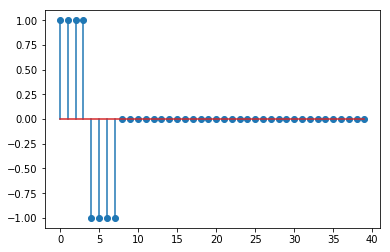

In [3]:
plt.stem(x_true)

In [4]:
def lasso_frank_wolfe(A, b, r, max_iter, use_linesearch, verbose=True):
    x = np.zeros(A.shape[1])
    Ax = np.dot(A, x)
    pobj = []
    for k in range(1, max_iter):
        # call the LMO
        i = np.argmax(np.abs(np.dot(A.T, Ax - b)))

        step_sign = np.sign(np.dot(A[:, i].T, b - Ax))  # sign of -gradF[i]
        s = np.zeros(n_features)
        s[i] = step_sign * r
        As = s[i] * A[:, i]  # = the i-th column of the design matrix A

        if use_linesearch:  # line-search on the univariate quadratic problem in gamma
            As_minus_Ax = As - Ax;
            gamma = np.dot(As_minus_Ax.T, b - Ax) / np.dot(As_minus_Ax, As_minus_Ax)
            gamma = max(0, min(1, gamma))  # project in [0, 1]
        else:
            gamma = 2. / (k + 2.)

        x = (1. - gamma) * x + gamma * s  # do the FW step
        Ax = (1 - gamma) * Ax + gamma * As  # lazy update of Ax

        f_at_x = linalg.norm(Ax - b)**2 / 2.
        if verbose:
            print('k=%02d - f=%f - i=%d - gamma=%1.3f - ||x_k||_1=%1.3f' %
                  (k, f_at_x, i, gamma, np.sum(np.abs(x))));

        pobj.append(f_at_x)

    return pobj, x

r = 1.  # the regularization constraint imposed on the l_1-norm
pobj_ls, x = lasso_frank_wolfe(A, b, r, max_iter=20, use_linesearch=False)

k=01 - f=84.622218 - i=5 - gamma=0.667 - ||x_k||_1=0.667
k=02 - f=81.572543 - i=0 - gamma=0.500 - ||x_k||_1=0.833
k=03 - f=77.758789 - i=5 - gamma=0.400 - ||x_k||_1=0.900
k=04 - f=76.241537 - i=6 - gamma=0.333 - ||x_k||_1=0.933
k=05 - f=75.664256 - i=5 - gamma=0.286 - ||x_k||_1=0.952
k=06 - f=75.516891 - i=7 - gamma=0.250 - ||x_k||_1=0.964
k=07 - f=75.106469 - i=5 - gamma=0.222 - ||x_k||_1=0.972
k=08 - f=75.049496 - i=0 - gamma=0.200 - ||x_k||_1=0.978
k=09 - f=74.746479 - i=5 - gamma=0.182 - ||x_k||_1=0.982
k=10 - f=74.570950 - i=6 - gamma=0.167 - ||x_k||_1=0.985
k=11 - f=74.489010 - i=5 - gamma=0.154 - ||x_k||_1=0.987
k=12 - f=74.546266 - i=0 - gamma=0.143 - ||x_k||_1=0.989
k=13 - f=74.430213 - i=5 - gamma=0.133 - ||x_k||_1=0.990
k=14 - f=74.386275 - i=6 - gamma=0.125 - ||x_k||_1=0.992
k=15 - f=74.346599 - i=5 - gamma=0.118 - ||x_k||_1=0.993
k=16 - f=74.357874 - i=7 - gamma=0.111 - ||x_k||_1=0.993
k=17 - f=74.307666 - i=5 - gamma=0.105 - ||x_k||_1=0.994
k=18 - f=74.324453 - i=0 - gamm

### Plot result

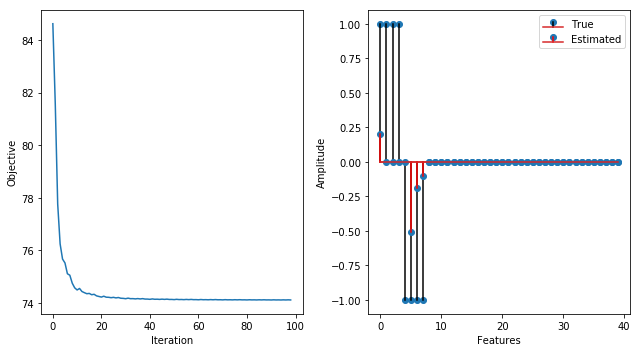

In [5]:
pobj_ls, x = lasso_frank_wolfe(A, b, r, max_iter=100,
                               use_linesearch=False, verbose=False)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
ax1.plot(pobj_ls)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Objective')

ax2.stem(x_true, 'k', label='True')
ax2.stem(x, 'r', label='Estimated')
ax2.set_xlabel('Features')
ax2.set_ylabel('Amplitude')
plt.legend()
plt.tight_layout();

## Look at convergence rates

First compute $f^*$ by running solver many iterations

In [6]:
pobj, _ = lasso_frank_wolfe(A, b, r, max_iter=10000, use_linesearch=True, verbose=False)
f_star = np.min(pobj)

The plot objective:

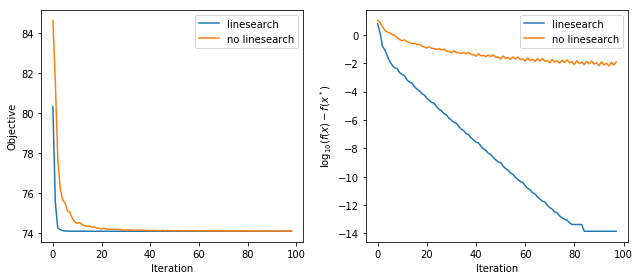

In [7]:
max_iter = 100
pobj_ls, _ = lasso_frank_wolfe(A, b, r, max_iter=max_iter, use_linesearch=True, verbose=False)
pobj_no_ls, _ = lasso_frank_wolfe(A, b, r, max_iter=max_iter, use_linesearch=False, verbose=False)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
ax1.plot(pobj_ls, label='linesearch')
ax1.plot(pobj_no_ls, label='no linesearch')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Objective')
ax1.legend()

ax2.plot(np.log10(pobj_ls[:-1] - f_star), label='linesearch')
ax2.plot(np.log10(pobj_no_ls[:-1] - f_star), label='no linesearch')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('$\log_{10}(f(x) - f(x^*)$')
ax2.legend()
plt.tight_layout();